# Part - C :- Self taught learning

#### In this part of the assignment, we are asked to construct an autoencoder to predict the labels of an image data. This is followed by creating a neural net for the same and finally creating an augmented self taught learner which first builds an autoencoder and uses the features learnt from the autoencoder and feeds it to the neural network.

We begin by installing h2o and loading all the necessary packages required.

In [2]:
# The following two commands remove any previously installed H2O packages for R.
if ("package:h2o" %in% search()) { detach("package:h2o", unload=TRUE) }
if ("h2o" %in% rownames(installed.packages())) { remove.packages("h2o") }

# Next, we download packages that H2O depends on.
pkgs <- c("RCurl","jsonlite")
for (pkg in pkgs) {
if (! (pkg %in% rownames(installed.packages()))) { install.packages(pkg) }
}

# Now we download, install and initialize the H2O package for R.
install.packages("h2o", type="source", repos="http://h2o-release.s3.amazonaws.com/h2o/rel-yau/8/R")


also installing the dependency 'bitops'



package 'bitops' successfully unpacked and MD5 sums checked
package 'RCurl' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\mmoh0064\AppData\Local\Temp\RtmpywkdUi\downloaded_packages


In [3]:
library(ggplot2)
install.packages('BBmisc')
library(BBmisc)
library(h2o)
options(warn=-1)
#If there is a proxy: proxy.old <- Sys.getenv('http_proxy'); Sys.setenv('http_proxy'='');
localH2O =  h2o.init(nthreads = -1, port = 54321, max_mem_size = '6G', startH2O = TRUE)



Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
also installing the dependency 'checkmate'



package 'checkmate' successfully unpacked and MD5 sums checked
package 'BBmisc' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\mmoh0064\AppData\Local\Temp\RtmpywkdUi\downloaded_packages



Attaching package: 'BBmisc'

The following object is masked from 'package:base':

    isFALSE


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: 'h2o'

The following objects are masked from 'package:stats':

    cor, sd, var

The following objects are masked from 'package:base':

    %*%, %in%, &&, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc




H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    C:\Users\mmoh0064\AppData\Local\Temp\RtmpywkdUi/h2o_mmoh0064_started_from_r.out
    C:\Users\mmoh0064\AppData\Local\Temp\RtmpywkdUi/h2o_mmoh0064_started_from_r.err


Starting H2O JVM and connecting: . Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         2 seconds 592 milliseconds 
    H2O cluster timezone:       Australia/Sydney 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.26.0.8 
    H2O cluster version age:    16 hours and 17 minutes  
    H2O cluster name:           H2O_started_from_R_mmoh0064_vyo456 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   5.33 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Interna

We now read the dataset and perform some pre-processing on it. In essence, we remove the NA values and standardize the features.

In [5]:
data_train_labeled <- read.csv('Task2C_labeled.csv')
data_train_unlabeled <- read.csv('Task2C_unlabeled.csv')

data_train_labeled <- na.omit(data_train_labeled) # remove NA values
data_train_unlabeled <- na.omit(data_train_unlabeled) # remove NA values

In [6]:
data_train_labeled$label <- as.factor(data_train_labeled$label) # converts the label to a factor
data_train_unlabeled$label <- as.factor(data_train_unlabeled$label) # converts the label to a factor


In [7]:
data_train_labeled <- normalize(data_train_labeled, method = "standardize", range = c(0, 1), margin = 2L) # standardizes the features of labelled data
data_train_unlabeled <- normalize(data_train_unlabeled, method = "standardize", range = c(0, 1), margin = 2L) # standardizes the features of unlabelled data


In [8]:
write.csv(data_train_labeled, file = "Task2C_labeled_v1.csv",row.names = FALSE)
write.csv(data_train_unlabeled, file = "Task2C_unlabeled_v1.csv",row.names = FALSE)

Below we write an auxiliary function for calculating error.

In [9]:
error.rate <- function(Y1, T1){
  if (nrow(Y1)!=nrow(T1)){
    stop('error.rate: size of true lables and predicted labels mismatch')
  }
  return (sum(T1!=Y1)/nrow(T1))
}

Below we assign a matrix to store reconstruction training error and read the data into a H2OFrame by using h2o.importfile

In [10]:
reconstruction.train.error <- matrix(NA, nrow=27, ncol=2)

# Students: Use the "absolute" path to the datasets on your machine (important)
labeled.frame <- h2o.importFile(path = 'C:/Users/mmoh0064/Task2C_labeled_v1.csv' ,sep=',')
unlabeled.frame <- h2o.importFile(path = 'C:/Users/mmoh0064/Task2C_unlabeled_v1.csv' ,sep=',')
test.frame <- h2o.importFile(path = 'C:/Users/mmoh0064/Task2C_test.csv' ,sep=',')

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


We now convert the labels to factors and remove the labels from unlabeled data. We then create train.frame which is a combination of labeled and unlabeled data.

In [11]:
labeled.frame[,1] <- as.factor(labeled.frame$label) #converting labels to factor for labeled data
unlabeled.frame[,1] <- NA #removing labels to factor for unlabeled data
train.frame <- h2o.rbind(labeled.frame[,-1], unlabeled.frame[,-1]) # binding labeled and unlabeled data together
test.frame[,1] <- as.factor(test.frame$label) # converting labels of test data to a factor.

Below we build an autoencoder by providing 20 to 500 number of neurons in thehidden layer and providing both labeled and unlabeled data with the Tanh activation function. For each of these models, we calculate the reconstruction error which is the average distance between the input and output of the autoencoder. This is stored in a dataframe and then we produce a plot to see how the reconstruction error varies as the number of neurons in the hidden layer increases.

In [31]:
i <- 1 # counter
for (k in seq(20, 500, 20))
    {
            # build a neural network classifier based on the labeled training data
            NN.model_encoder <- h2o.deeplearning(    
            x = 2:ncol(train.frame), # select all pixels + extra features
            training_frame = train.frame, # specify the frame (imported file)    
            hidden = c(k), # number of layers and their units
            epochs = 50, # maximum number of epoches  
            activation = 'Tanh', # activation function
            autoencoder = TRUE, # is it an autoencoder? Yes!
            l2 = 0.1)
            reconstruction_error <- mean(h2o.anomaly(NN.model_encoder, train.frame)) # reconstruction error which is the mean of distance between the input and output
            reconstruction.train.error[i, 1] <- k # stores the number of neurons 
            reconstruction.train.error[i, 2] <- reconstruction_error # the reconstruction error for the corresponding error
            i=i+1 # increment the counter
    }

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

In [32]:
reconstruction.train.error <- data.frame(reconstruction.train.error) # creates a dataframe to store the error for varying number of neurons

Below we plot the reconstruction error v/s number of neurons used to build the autoencoder.

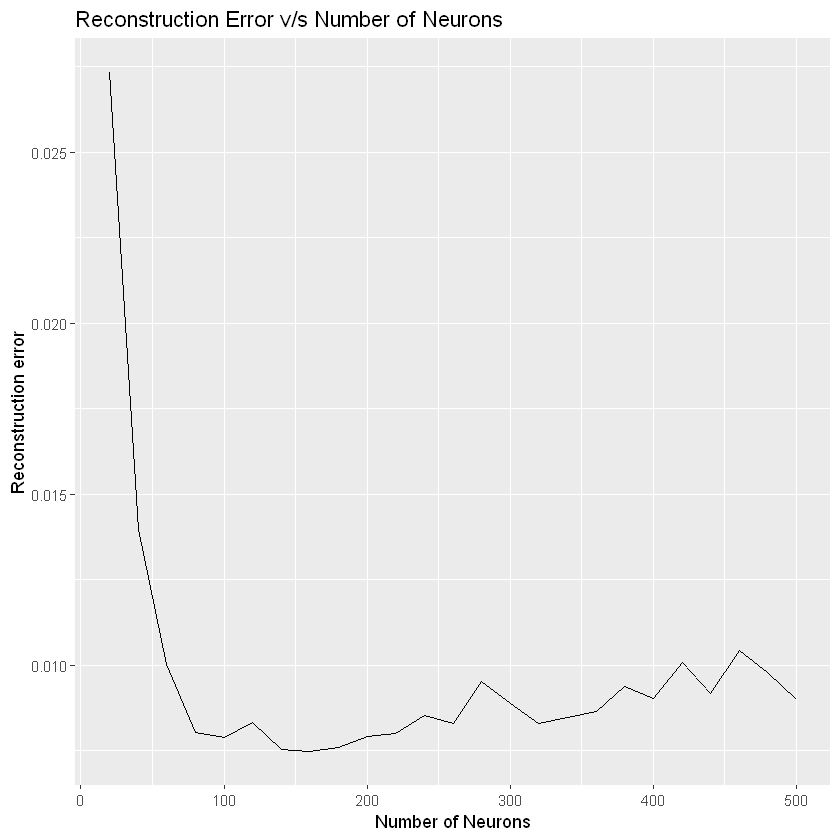

In [33]:
ggplot(data=reconstruction.train.error,aes(x=X1,y=X2)) + 
    geom_line() + 
    labs(x="Number of Neurons") + 
    labs(y="Reconstruction error") + 
    labs(title = "Reconstruction Error v/s Number of Neurons")

We now use the 3 layer neural network model provided in activity 5.2 with three layers and 100 neurons in the hidden layer with Tanh as the activation function. We then record the error rate in its prediction.

In [26]:
NN.model <- h2o.deeplearning(    
  x = 2:ncol(labeled.frame), # select all pixels + extra features
  y = 1,
  training_frame = labeled.frame, # specify the  only labeled data    
  hidden = c(100), # number of layers and their units
  epochs = 50, # maximum number of epoches  
  activation = 'Tanh', # activation function
  autoencoder = FALSE, # is it an autoencoder? No!
  l2 = 0.1
)



  |======================================================================| 100%


In [27]:
predicted_label <- h2o.predict(NN.model, test.frame)$predict
error.rate(test.frame$label, predicted_label)

  |======================================================================| 100%


[1] 0.739

Below we build an autoencoder with 20,40,60.....500 neurons in the hidden layers. We then use the extra features generated from the autoencoder to the training data and feed it to the neural network. This is followed by recording the error for different numbers of k.

In [28]:
# Create a matrix to store all the test errors
classification.test.error <- matrix(NA, nrow=25, ncol=1)


## loop over different k value of neurons and nuild autoencder and NN based on it
for (k in seq(20, 500, 20)){
        ## Autoencoder  
        NN.model_encoder <- h2o.deeplearning(    
        x = 2:ncol(train.frame), # select all pixels + extra features
        training_frame = train.frame, # specify the frame (imported file)    
        hidden = c(k), # number of layers and their units
        epochs = 50, # maximum number of epoches  
        activation = 'Tanh', # activation function 
        autoencoder = TRUE, # is it an autoencoder? Yes!
        l2 = 0.1
)
  
        #augmented dataframe with features of autoencoder and labelled data for NN
        labeled.frame.ex <- h2o.cbind(labeled.frame,as.numeric(h2o.deepfeatures(NN.model_encoder,labeled.frame,layer=1)))  
  
        ## NN model for augmentaed labelled data set
        NN.model_NN <- h2o.deeplearning(    
            x = 2:ncol(labeled.frame.ex), # select all pixels + extra features
            y = 1,
            training_frame = labeled.frame.ex, # specify the frame (imported file)    
            hidden = c(k), # number of layers and their units
            epochs = 50, # maximum number of epoches  
            activation = 'Tanh', # activation function 
            autoencoder = FALSE, # is it an autoencoder? No!
            l2 = 0.1
        )
  
        #make test data predictions and calculate errors
        test.predict <- h2o.predict(NN.model_NN, test.frame)$predict
        classification.test.error[k/20] <-error.rate(test.frame$label, test.predict)  
}

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

Below we create a dataframe to store the classification errors from the neural net for different number of features.

In [29]:
df <- data.frame('K'= seq(20,500,20),'ClassificationError'=classification.test.error)


We now plot the classification error rate against number of features.

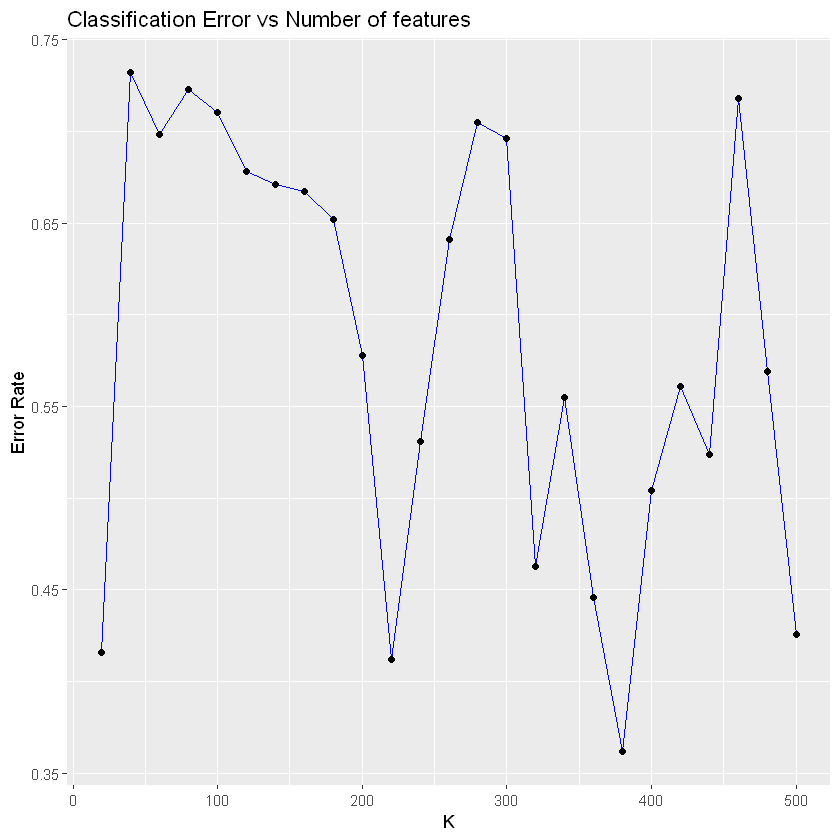

In [30]:
ggplot(data = df,aes(x=df[,1],y=df[,2])) + 
geom_line(color = 'blue') + 
geom_point() +
ggtitle('Classification Error vs Number of features') +
ylab('Error Rate') + 
xlab('K')